# MiniProject Biriukova Kateryna

## Task description:
<b>Option 2:</b> Think about anomaly detection use-case, find or create(preferable) a corresponding dataset. Search and study suitable Deep Learning based approaches to address this issue (e.g. AutoEncoders, or something else). Implement your solution.

## The Task is: Credit Cards Fraud Detection

In [13]:
# necessary imports

import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score


In [14]:
# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

### The chosen dataset is Credit Card Fraud Detection Dataset
(<i>https://www.openml.org/search?type=data&sort=runs&id=42175&status=active</i>)

### Preparing the data

In [15]:
# load the dataset
df = pd.read_csv('creditcard.csv')

# setting random seeds for libraries
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.keras.utils.set_random_seed(RANDOM_SEED)

In [16]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [17]:
# rename the columns
df.columns = map(str.lower, df.columns)
df.rename(columns={'class': 'label'}, inplace=True)


In [18]:
# turn the amount feature into a normally distributed log equivalent
df['log10_amount'] = np.log10(df.amount + 0.00001)

In [19]:
# put the label field at the back of the dataset
df = df[
    [col for col in df if col not in ['label', 'log10_amount']] + 
    ['log10_amount', 'label']
]

In [20]:
# VISUALISING THE DATA USING t-SNE (we will undersample the clean transactions and feed the t-SNE only with a small part of data)

RATIO_TO_FRAUD = 15
# drop redundant columns
df = df.drop(['time', 'amount'], axis=1)

# split by class
fraud = df[df.label == 1]
clean = df[df.label == 0]

# undersample clean transactions
clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED
)

# concatenate with fraud transactions into a single dataset
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)
# isolate features from labels 
features, labels = visualisation_initial.drop('label', axis=1).values, \
                   visualisation_initial.label.values

In [21]:
print(f"The clean to fraud ratio is {RATIO_TO_FRAUD}:1")

The clean to fraud ratio is 15:1


In [22]:
# plot the t-SNE
def tsne(features, labels, dimensions=2, save_as='graph.png'):

    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)
    fig, ax = plt.subplots(figsize=(8,8))
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

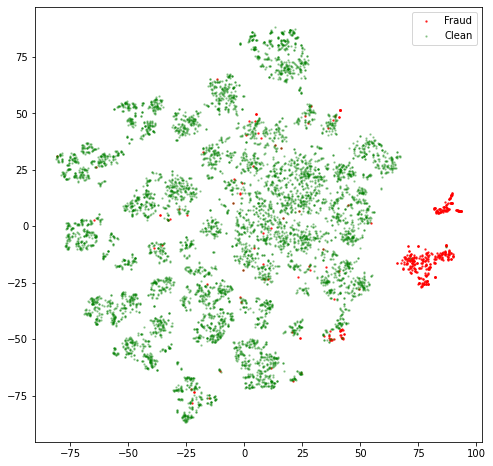

In [11]:
# plot the t-SNE
tsne(features, labels, dimensions=2, save_as='tsne_start.png')

The models will be trained only on transactions that were normal. The test sample will be formed through combining the part of the "clean" dataset, which was not used for training, and the "fraud" dataset.

In [23]:
print(f"""Shape of the datasets:
    clean = {clean.shape}
    fraud = {fraud.shape}""")

Shape of the datasets:
    clean = (284315, 30)
    fraud = (492, 30)


In [24]:
# shuffle training set
clean = clean.sample(frac=1).reset_index(drop=True)

# form the training set: only 'clean' transactions
X_train = clean.iloc[:TRAINING_SAMPLE].drop('label', axis=1)

# form the test set: the remaining clean + all fraud 
X_test = clean.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)

In [25]:
print(f"""How is the testing set composed:

{X_test.label.value_counts()}""")

How is the testing set composed:

0    84315
1      492
Name: label, dtype: int64


In [26]:
# make train and validation sets - all clean
X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# split the labels from the test dataset
X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values

In [28]:
print(f"""Shape of the datasets:
    training = {X_train.shape}
    validate = {X_validate.shape}
    holdout = {X_test.shape}""")

Shape of the datasets:
    training = (160000, 29)
    validate = (40000, 29)
    holdout = (84807, 29)


In [29]:
# NORMALISING AND STANDARDASING 

# configure the pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [30]:
# Fit the pipeline: get normalization parameters by fitting to the training data
pipeline.fit(X_train)

Pipeline(steps=[('normalizer', Normalizer()), ('scaler', MinMaxScaler())])

In [32]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

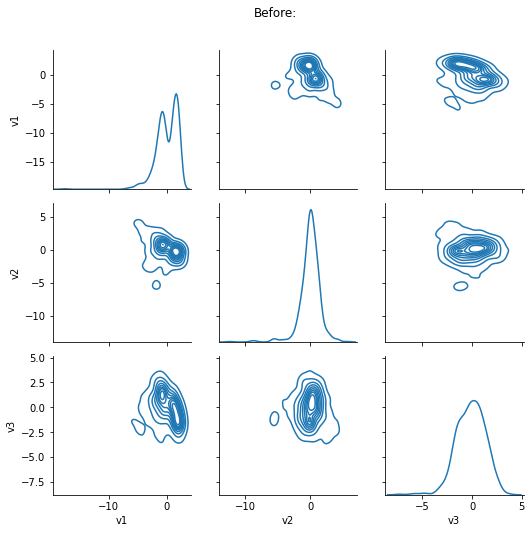

In [33]:
# visualise the training data before and after
g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

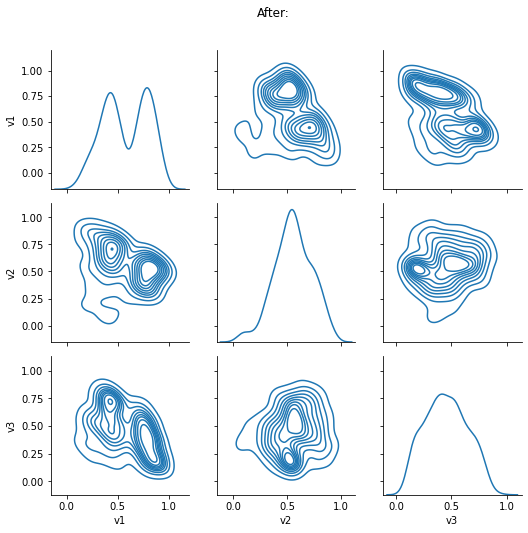

In [34]:
#the "after-data" became more proportionally distributed
g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=column_names).iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

# The AutoEncoder

In [35]:
# start TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs

In [36]:
# data dimensions and hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

In [37]:
# create autoencoder
autoencoder = tf.keras.models.Sequential([
    # encoder
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(32, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # decoder
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(32, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# print an overview of the model
autoencoder.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 29)                870       
                                                                 
 dense_1 (Dense)             (None, 32)                960       
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
 dense_5 (Dense)             (None, 2)                 10        
                                                                 
 dense_6 (Dense)             (None, 4)                 1

### Callbacks
(for early stop and TensorBoard)

In [38]:
# create the function for callbacks creation
def create_callbacks(model, name):
    
    yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
    log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(model.layers)}'

# define early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0000001,
        patience=70,
        verbose=1, 
        mode='min',
        restore_best_weights=True
    )

    save_model = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{name}_best_weights.hdf5',
        save_best_only=True,
        monitor='val_loss',
        verbose=0,
        mode='min'
    )

    tensorboard = tf.keras.callbacks.TensorBoard(
        f'logs/{log_subdir}',
        batch_size=BATCH_SIZE,
        update_freq='batch'
    )

# make a callback
    cb = [save_model, tensorboard, early_stop]
    return cb

In [39]:
# create the callbecks for autoencoder
cb = create_callbacks(autoencoder, 'autoencoder')

In [40]:
# train the autoencoder
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Epoch 1/100
625/625 [==============================] - 4s 4ms/step - loss: 0.0284 - acc: 0.2397 - val_loss: 0.0154 - val_acc: 0.2600
Epoch 2/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0146 - acc: 0.3288 - val_loss: 0.0143 - val_acc: 0.3462
Epoch 3/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0140 - acc: 0.3293 - val_loss: 0.0138 - val_acc: 0.3403
Epoch 4/100
625/625 [==============================] - 2s 4ms/step - loss: 0.0134 - acc: 0.3535 - val_loss: 0.0131 - val_acc: 0.3657
Epoch 5/100
625/625 [==============================] - 2s 4ms/step - loss: 0.0129 - acc: 0.3771 - val_loss: 0.0127 - val_acc: 0.3658
Epoch 6/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0126 - acc: 0.3676 - val_loss: 0.0126 - val_acc: 0.3593
Epoch 7/100
625/625 [==============================] - 2s 4ms/step - loss: 0.0125 - acc: 0.3682 - val_loss: 0.0125 - val_acc: 0.3714
Epoch 8/100
625/625 [==============================] - 2s 4ms/step - 

625/625 [==============================] - 2s 3ms/step - loss: 0.0089 - acc: 0.4502 - val_loss: 0.0090 - val_acc: 0.4435
Epoch 63/100
625/625 [==============================] - 2s 4ms/step - loss: 0.0089 - acc: 0.4502 - val_loss: 0.0090 - val_acc: 0.4526
Epoch 64/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0089 - acc: 0.4507 - val_loss: 0.0089 - val_acc: 0.4423
Epoch 65/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0089 - acc: 0.4494 - val_loss: 0.0089 - val_acc: 0.4399
Epoch 66/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0089 - acc: 0.4503 - val_loss: 0.0089 - val_acc: 0.4424
Epoch 67/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0089 - acc: 0.4519 - val_loss: 0.0089 - val_acc: 0.4446
Epoch 68/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0089 - acc: 0.4512 - val_loss: 0.0089 - val_acc: 0.4502
Epoch 69/100
625/625 [==============================] - 2s 3ms/step - loss:

In [41]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

/Users/jitunath/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


2651/2651 [==============================] - 2s 743us/step


In [42]:
# calculating the mean squared error per row
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

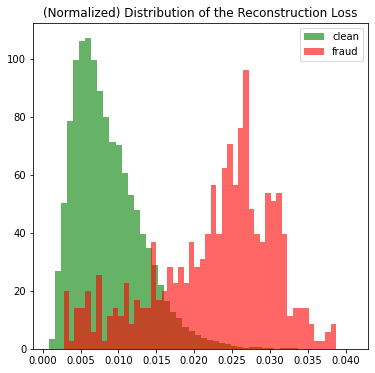

In [43]:
clean = mse[y_test==0]
fraud = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [47]:
# use a modified Z-score using the Median Absolute Deviation to define outliers on reconstruction data
THRESHOLD = 3

def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [48]:
# function to create confusion matrix
def build_confusion_matrix(y_test, outliers, name):
# make a confusion matrix on MAD outliers
    cm = confusion_matrix(y_test, outliers)
# true/false positives/negatives
    (tn, fp,    
    fn, tp) = cm.flatten()
    print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
    {cm}

    % of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
    % of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")
# visualise the confusion matrix
    ax = sns.heatmap(cm, annot=True, 
                fmt='', cmap='Blues')

    ax.set_title(f'{name} - Confusion Matrix\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    plt.show()

The classifications using the MAD method with threshold=3 are as follows:
    [[82903  1412]
 [  157   335]]

    % of transactions labeled as fraud that were correct (precision): 335/(1412+335) = 19.18%
    % of fraudulent transactions were caught succesfully (recall):    335/(157+335) = 68.09%


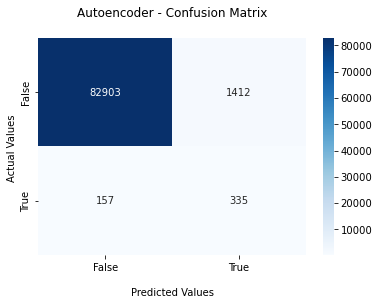

In [49]:
# build and show confusion matrix for the autoencoder
build_confusion_matrix(y_test, outliers, 'Autoencoder')

### Precision and Recall recalculated

In [51]:
from sklearn.metrics import accuracy_score, auc, balanced_accuracy_score, confusion_matrix, f1_score, precision_score, average_precision_score, roc_auc_score,  recall_score,  precision_recall_curve #some scoring functions
# Performance checking with differnt metrics
def print_scores(y_t, y_p):
    print(f'Accuracy  :{accuracy_score(y_t, y_p):.2f}' )
    print(f'Balanced  :{balanced_accuracy_score(y_t, y_p):.2f}' )
    print(f'F1        :{f1_score(y_t, y_p):.2f}' )
    print(f'Precision :{precision_score(y_t, y_p):.2f}' )
    print(f'Recall    :{recall_score(y_t, y_p):.2f}' )
    print(f'roc auc   :{roc_auc_score(y_t, y_p):.2f}' )
    print(f'pr)auc    :{average_precision_score(y_t, y_p):.2f}' )
print_scores(y_test, outliers )

Accuracy  :0.98
Balanced  :0.83
F1        :0.30
Precision :0.19
Recall    :0.68
roc auc   :0.83
pr)auc    :0.13


In [52]:
# function to build and show the AUC & ROC Curve
def build_auc_roc(y_test, outliers, name):
    # build and show the AUC & ROC Curve
    auc = metrics.roc_auc_score(y_test, outliers)

    false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, outliers)

    plt.figure(figsize=(10, 8), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title(f"{name}: AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'b')
    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightblue', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    print('roc_auc_score of RF: ', roc_auc_score(y_test, outliers))

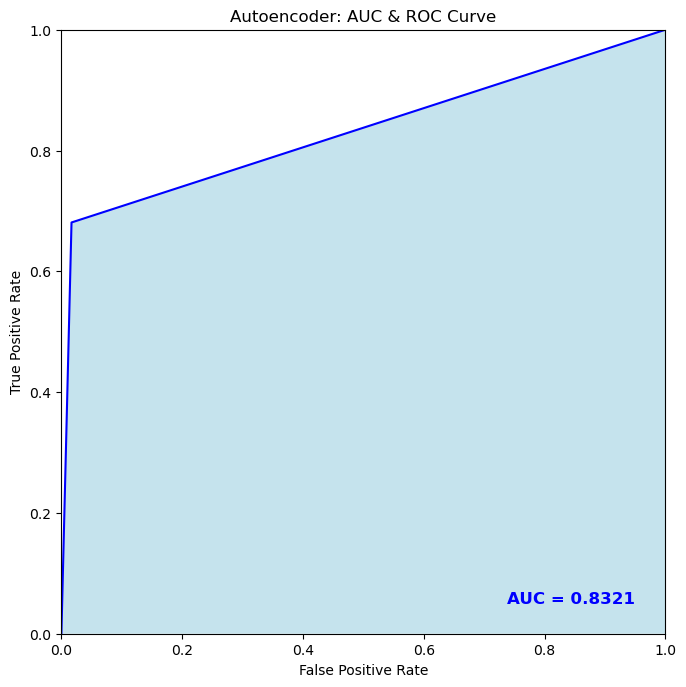

roc_auc_score of RF:  0.8320737926735254


In [53]:
# build and show AUC & ROC Curve for the autoencoder
build_auc_roc(y_test, outliers, 'Autoencoder')